## Dataset Generation

In [1]:
import sys
sys.path.append('../src')
import citibike_trips

In [2]:
ds = citibike_trips.DataStore("mongodb://localhost:27017")

In [3]:
from collections import Counter
line_segments_counter = Counter()

from tqdm import tqdm

for tripid in tqdm(ds.get_all_trip_ids()):
    trip = ds.get_trip_by_id(tripid)
    geom = trip['geometry']['coordinates']
    for prior_i, next_i in zip(range(0, len(geom) - 1), range(1, len(geom))):
        line_segment_prior = geom[prior_i]
        line_segment_next = geom[next_i]
        line_segments_counter[(line_segment_prior[0], line_segment_prior[1], 
                               line_segment_next[0], line_segment_next[1])] += 1

100%|████████████████████████████████████| 56744/56744 [18:30<00:00, 51.09it/s]


In [4]:
import pandas as pd

linesegments = pd.DataFrame\
                    .from_dict(line_segments_counter, orient='index')\
                    .reset_index()\
                    .rename(columns={0: 'Count', 'index': 'Tuple'})
linesegments['Start X'] = [tup[0] for tup in linesegments['Tuple']]
linesegments['Start Y'] = [tup[1] for tup in linesegments['Tuple']]
linesegments['End X'] = [tup[2] for tup in linesegments['Tuple']]
linesegments['End Y'] = [tup[3] for tup in linesegments['Tuple']]

In [9]:
linesegments.head()

,Tuple,Count,Start X,Start Y,End X,End Y
0,"(40.70481, -74.01624, 40.70482, -74.01612)",203,40.70481,-74.01624,40.70482,-74.01612
1,"(40.78307, -73.98454, 40.78303, -73.98456)",50,40.78307,-73.98454,40.78303,-73.98456
2,"(40.71646, -73.95042, 40.71602, -73.95106)",2,40.71646,-73.95042,40.71602,-73.95106
3,"(40.73026, -73.99799, 40.7303, -73.99808)",100,40.73026,-73.99799,40.73030,-73.99808
4,"(40.73924, -73.99918, 40.73989, -73.99873)",57,40.73924,-73.99918,40.73989,-73.99873


In [8]:
linesegments.sort_values(by='Count', ascending=False).head()

,Tuple,Count,Start X,Start Y,End X,End Y
13864,"(40.73687, -74.00556, 40.73687, -74.00556)",2177,40.73687,-74.00556,40.73687,-74.00556
10464,"(40.75193, -73.99365, 40.75205, -73.99356)",2113,40.75193,-73.99365,40.75205,-73.99356
32407,"(40.75205, -73.99356, 40.75219, -73.99345)",2113,40.75205,-73.99356,40.75219,-73.99345
29484,"(40.75094, -73.99436, 40.7512, -73.99418)",2033,40.75094,-73.99436,40.75120,-73.99418
27595,"(40.7512, -73.99418, 40.75151, -73.99395)",2033,40.75120,-73.99418,40.75151,-73.99395


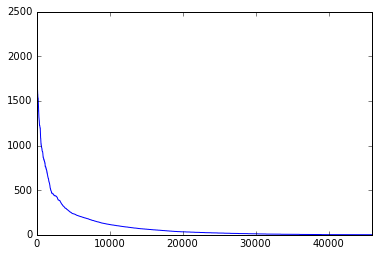

In [11]:
%matplotlib inline
linesegments['Count'].sort_values(ascending=False).reset_index()['Count'].plot()

In [16]:
linesegments.to_csv("../data/linesegments.csv")

In [40]:
linesegments.sample(5)['Tuple'].values

array(['(40.7491, -73.99201, 40.7491, -73.99201)',
       '(40.70777, -74.01577, 40.70862, -74.01546)',
       '(40.69509, -73.98891, 40.69509, -73.98874)',
       '(40.71973, -73.98281, 40.71999, -73.98364)',
       '(40.70149, -73.96119, 40.70132, -73.96128)'], dtype=object)

Testing to make sure the data is structured correctly.

In [55]:
import mplleaflet
import matplotlib.pyplot as plt

%matplotlib inline
for ar in linesegments.sample(100)['Tuple'].values:
    a = eval(ar)  # sorry.
    plt.plot([a[1], a[3]], [a[0], a[2]], linewidth=10)

mplleaflet.show()

## Visualization Prototyping

In [3]:
%run ../src/py-d3

In [4]:
%%d3

<g id="map_holder"></g>

<script>
var width = 960;
var height = 450;
var line_scale_factor = 2;

var svg = d3.select("#map_holder")
        .append("svg")
        .attr("width", 1000)
        .attr("height", 800);

svg.append("rect")
    .attr("width", "100%")
    .attr("height", "100%")
    .attr("fill", "lightsteelblue");        

var proj = d3.geo.mercator()
        .center([-74.04, 40.825])
        .scale(80000)
        .translate([(width) / 2, (height)/2]);

var path = d3.geo.path()
        .projection(proj);
        
d3.json("../data/boroughs.geojson", function(error, nyc) {
    if (error) return console.error(error);

    svg.append("path")
        .datum(nyc)
        .attr("d", path)
        .attr({
                "fill": "#fefcfa"
            })

});

d3.csv("../data/linesegments.csv", function(error, linesegments) {
    if (error) return console.error(error);
    
    var links = [];
        
    for(var i=0, len=linesegments.length-1; i<len; i++) {
        links.push({
            type: "LineString",
            coordinates: [
                [ linesegments[i]['Start Y'], linesegments[i]['Start X'] ],
                [ linesegments[i+1]['End Y'], linesegments[i+1]['End X'] ]
            ]
        });
    }
        
    console.log(links);
        
    svg
        .selectAll("path")
        .data(links)
        .enter()
        .append("path")
        .attr("d", path)
        .attr({
                "stroke": "orange",
                "stroke-width": "1"
            })

});
</script>